# OECD - International comparisons - new API

https://data-explorer.oecd.org/?lc=en

## Python setup

In [1]:
# system imports
from io import StringIO
from pathlib import Path
from typing import Any, Sequence, cast
import time

In [2]:
# analytic imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

In [3]:
# local imports
import common
import plotting as pg

In [4]:
# plotting stuff
plt.style.use("fivethirtyeight")
TARGET = {
    "ymin": 2,
    "ymax": 3,
    "color": "#dddddd",
    "label": "2-3% inflation target",
    "zorder": -1,
}
TARGET_V = TARGET | {"xmin": 2, "xmax": 3}
del TARGET_V["ymax"]
del TARGET_V["ymin"]

# Where to put the charts
CHART_DIR = "./CHARTS/OECD/"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
pg.set_chart_dir(CHART_DIR)

# Remove old charts
for filename in Path(CHART_DIR).glob("*.png"):
    filename.unlink()

# display charts in notebook
SHOW = True

## Utility functions for OECD data capture

In [5]:
location_map = {
    "AUS": "Australia",
    "AUT": "Austria",
    "BEL": "Belgium",
    "CAN": "Canada",
    "CHL": "Chile",
    "CZE": "Czech Rep.",
    "DNK": "Denmark",
    "EST": "Estonia",
    "FIN": "Finland",
    "FRA": "France",
    "DEU": "Germany",
    "GRC": "Greece",
    "HUN": "Hungary",
    "ISL": "Iceland",
    "IRL": "Ireland",
    "ISR": "Israel",
    "ITA": "Italy",
    "JPN": "Japan",
    "KOR": "Korea",
    "LVA": "Latvia",
    "LUX": "Luxembourg",
    "MEX": "Mexico",
    "NLD": "Netherlands",
    "NZL": "New Zealand",
    "NOR": "Norway",
    "POL": "Poland",
    "PRT": "Portugal",
    "SVK": "Slovak Rep.",
    "SVN": "Slovenia",
    "ESP": "Spain",
    "SWE": "Sweden",
    "CHE": "Switzerland",
    "TUR": "Türkiye",
    "GBR": "United Kingdom",
    "USA": "United States",
    "ARG": "Argentina",
    "BRA": "Brazil",
    "CHN": "China",
    "COL": "Colombia",
    "CRI": "Costa Rica",
    "IND": "India",
    "IDN": "Indonesia",
    "LTU": "Lithuania",
    "RUS": "Russia",
    "SAU": "Saudi Arabia",
    "ZAF": "South Africa",
    "ROU": "Romania",
    "BGR": "Bulgaria",
    "HRV": "Croatia",
}

In [6]:
def get_oecd_table(
    agency: str, dataflow: str, filter_expr: str, options: str
) -> pd.DataFrame:
    """Capture a DataFrame from the OECD data API.
    OECD updated data API:
        https://sdmx.oecd.org/public/rest/data/
        <agency identifier>,<dataflow identifier>,<dataflow version>/
        <filter expression>[?<optional parameters>]

    Use https://data-explorer.oecd.org/?lc=en
    to get the necessary identifiers."""

    stem = "https://sdmx.oecd.org/public/rest/data"
    options = options + "&format=csv"
    options = options[1:] if options[0] == "&" else options

    url = f"{stem}/{agency},{dataflow}/{filter_expr}?{options}"
    contents = common.request_get(url).decode("utf-8")
    df = pd.read_csv(StringIO(contents))
    pvt = df.pivot(index="TIME_PERIOD", columns="REF_AREA", values="OBS_VALUE")

    pvt = pvt.dropna(how="all", axis=1)
    pvt = pvt.dropna(how="all", axis=0)

    return pvt


SOURCE = "OECD Data Explorer"

In [7]:
def check_missing(df: pd.DataFrame) -> None:
    """Check data downloaded from OECD for missing columns."""

    # external check:
    missing = list(set(location_map.keys()) - set(df.columns))
    if missing:
        text = ", ".join([location_map[x] for x in missing])
        print(f"Missing national data for {text}")

    # internal check
    final_row = df.iloc[-1]
    missing_count = final_row.isna().sum()
    if missing_count:
        print(f"Final period: {final_row.name}")
        print(f"Missing data count for final period: {missing_count}")
        print(f"Missing data belongs to: {df.columns[final_row.isna()].to_list()}")
        print(f"Nations with final data: {df.columns[final_row.notna()].to_list()}")

In [8]:
def remove_non_national(df: pd.DataFrame) -> pd.DataFrame:
    """Remove non-national columns."""

    remove = df.columns.difference(pd.Index(location_map.keys()))
    if len(remove):
        print(f"Removing columns: {remove}")
        df = df.drop(remove, axis=1)
    return df

In [9]:
def combine(left: None | pd.DataFrame, right: pd.DataFrame) -> pd.DataFrame:
    """Concatenate two DataFrames horizontally.
    Ignore columns in right that we already have in left.
    Therefore you need to capture the most relevant dataflows first.
    Used when we need combine get data from multiple OECD tables."""

    if left is None:
        left = right
    else:
        duplicates = left.columns.intersection(right.columns)
        if len(duplicates):
            right = right.drop(duplicates, axis=1)
        left = pd.concat([left, right], axis=1)

    return left

In [10]:
def fix_monthly(df: pd.DataFrame) -> pd.DataFrame:
    """Fix quarterly data as monthly. Note, where the OECD places
    quarterly data in a monthly series, it places this data in the
    mid-quarter month. So we will replicate with the conversion of
    quarterly fsts to monthly."""

    df.index += 1  # mid-period
    index = pd.period_range(start=df.index.min(), end=df.index.max())
    df = df.reindex(index)
    df = df.interpolate(limit_area="inside", limit=2, axis=0)
    return df

In [11]:
WEB_DELAY = 2  # seconds

## Utility functions for plotting

In [12]:
def get_chart_groups() -> dict[str, list[str]]:
    """Get chart groups, with no more than 6 lines
    per chart."""

    of_interest = ["AUS", "USA", "CAN", "DEU", "GBR", "JPN"]
    anglosphere = ["AUS", "USA", "CAN", "NZL", "GBR", "IRL"]
    major_europe = ["FRA", "DEU", "ITA", "GBR", "RUS", "ESP"]
    largest_economies = ["USA", "CHN", "JPN", "DEU", "GBR", "IND"]
    asia = ["KOR", "JPN", "CHN", "IND", "IDN"]
    north_europe = ["DNK", "SWE", "NOR", "ISL", "FIN", "GBR"]
    baltic_europe = ["LVA", "LTU", "EST"]
    central_europe = ["CZE", "HUN", "SVK", "SVN", "POL", "GRC"]
    west_europe = ["BEL", "ESP", "PRT", "NLD", "LUX", "FRA"]
    italo_germanic_europe = ["DEU", "AUT", "CHE", "ITA"]
    n_america = ["USA", "CAN", "MEX"]
    c_s_america = ["CHL", "BRA", "COL", "CRI"]
    other = ["AUS", "NZL", "SAU", "ZAF", "ISR"]
    high_inflation = [
        "TUR",
        "ARG",
    ]

    charts = {
        "of_interest": of_interest,
        "anglosphere": anglosphere,
        "major_europe": major_europe,
        "largest_economies": largest_economies,
        "asia": asia,
        "north_europe": north_europe,
        "baltic_europe": baltic_europe,
        "central_europe": central_europe,
        "west_europe": west_europe,
        "italo_germanic_europe": italo_germanic_europe,
        "n_america": n_america,
        "c_s_america": c_s_america,
        "high_inflation": high_inflation,
        "other": other,
    }

    return charts


chart_sets = get_chart_groups()

In [13]:
PW_COUNTER = 0  # global filename suffix - I know, ugly.

In [14]:
MEAN_MEDIAN = 0.80  # proportion of non-na data points to plot mean and median


def plot_world(
    data: pd.DataFrame,
    exclusions: None | list[str] = None,
    **kwargs: Any,
) -> None:
    """Plot Australia vs the OECD monitored mean and median."""

    # Exclude problematic OECD states
    data = data.rename(columns=location_map)
    if exclusions is not None:
        for c in exclusions:
            if c in data.columns:
                data = data.drop(c, axis=1)

    # plot remaining OECD states without legend label using the _ trick
    mapper = {x: f"_{x}" for x in data.columns}
    data = data.rename(columns=mapper)
    ax = data.plot(color="blue", lw=0.25, alpha=0.5)
    back = {y: x for x, y in mapper.items()}
    data = data.rename(columns=back)

    # plot mean if THRESHOLD proportion of non-na data points met
    mean = data.mean(axis=1).where(
        data.notna().sum(axis=1) >= len(data.columns) * MEAN_MEDIAN,
        other=np.nan,
    )
    median = data.median(axis=1).where(
        data.notna().sum(axis=1) >= len(data.columns) * MEAN_MEDIAN,
        other=np.nan,
    )
    mean.plot(ax=ax, color="darkblue", ls="--", lw=2, label="OECD monitored mean")
    median.plot(ax=ax, color="darkred", ls=":", lw=2, label="OECD monitored median")

    # plot
    data["Australia"].dropna().plot(ax=ax, color="darkorange", lw=3, label="Australia")
    global PW_COUNTER  # yes, this is ugly
    PW_COUNTER = PW_COUNTER + 1
    pg.finalise_plot(
        ax,
        xlabel=None,
        y0=True,
        rfooter=SOURCE,
        tag=str(PW_COUNTER),
        legend={"loc": "best", "fontsize": "xx-small"},
        **kwargs,
        show=SHOW,
    )

In [15]:
def plot_annual(data: pd.DataFrame, **kwargs: Any) -> None:
    """Quick Annual Charts, based on chart_sets from above."""

    for tag, chart_set in chart_sets.items():
        chart_set = sorted(set(chart_set).intersection(set(data.columns)))
        cs = data[chart_set].rename(columns=location_map)
        pg.line_plot(
            cs,
            tags=tag,
            xlabel=None,
            dropna=True,
            y0=True,
            width=2,
            rfooter=SOURCE,
            **kwargs,
            show=SHOW,
        )

#### OHLC plotting

In [16]:
OHLC_DEFAULT_N = 13  # months

In [17]:
def get_recent_ohlc(
    data: pd.DataFrame,
    n: int = OHLC_DEFAULT_N,  # months
    exclude: Sequence = (),  # excluded nations
) -> pd.DataFrame:
    """For a dataset, build a table of Open, Highm Low, Close
    points for last valid n months in each column."""

    # compare progress over 13 (12 + 1) months because Australia
    # and New Zealand only collect CPI measures quarterly
    index = ["Open", "High", "Low", "Close"]
    summary = pd.DataFrame([], index=index)  # return vehicle
    for name in data.columns:
        if name in exclude:
            continue
        column = data[name]
        last_valid = cast(pd.Period, column.last_valid_index())  # mypy cast
        time_period = pd.period_range(end=last_valid, periods=n)
        if time_period.min() < column.index.min():
            continue
        frame = column[time_period]
        open_ = frame.iloc[0]
        high = frame.max()
        low = frame.min()
        close = frame.iloc[-1]
        key = f"{name} {str(last_valid.year)[2:]}-{last_valid.month:02d}"
        summary[key] = pd.Series([open_, high, low, close], index=index)
    summary = summary.T.sort_values("Close")
    return summary

In [18]:
def plot_ohlc(
    ohlc_df: pd.DataFrame,
    horizontal: bool = True,  # horizontal v vertical bars
    n: int = OHLC_DEFAULT_N,  # months
    **kwargs: Any,
) -> None:
    """Plot data in ohlc_df in a open-high-low-close style."""

    def xy(x, y):
        return (x, y) if horizontal else (y, x)

    def set_limits(ax: plt.Axes) -> None:
        minimum = min(0, ohlc_df["Low"].min())  # include zero
        maximum = ohlc_df["High"].max()
        adjustment = (maximum - minimum) * 0.025
        limits = minimum - adjustment, maximum + adjustment
        if horizontal:
            ax.set_xlim(*limits)
        else:
            ax.set_ylim(*limits)

    # default settings
    kwargs["lfooter"] = kwargs.get(
        "lfooter",
        "Year and month of latest print in the axis labels. "
        f"Range is the {n} months up to and including the latest data. ",
    )
    kwargs["rfooter"] = kwargs.get("rfooter", SOURCE)
    kwargs["legend"] = kwargs.get("legend", {"loc": "best", "fontsize": "6"})
    kwargs["y0"] = kwargs.get("y0", not horizontal)
    kwargs["x0"] = kwargs.get("x0", horizontal)

    # canvass
    _, ax = plt.subplots()

    # sort out chart orientation
    good, bad = "darkblue", "darkorange"  # for colour blindness
    bar_method = ax.barh if horizontal else ax.bar
    reference: str = "left" if horizontal else "bottom"
    range_ = ohlc_df["High"] - ohlc_df["Low"]
    open_marker = "^" if horizontal else "<"
    close_marker = "v" if horizontal else ">"
    color = [
        good if open > close else bad
        for open, close in zip(ohlc_df.Open, ohlc_df.Close)
    ]

    # plot
    base: dict[str, np.ndarray] = {reference: ohlc_df["Low"].to_numpy()}
    bar_method(  # type: ignore[arg-type]
        ohlc_df.index,
        range_,
        color=color,
        linewidth=1.0,
        edgecolor="black",
        label=f"Range of prints through the {n} months",
        alpha=0.15,
        **base,  # type: ignore[arg-type]
    )
    ax.plot(
        *xy(ohlc_df["Open"], ohlc_df.index),
        marker=open_marker,
        linestyle="None",
        label=f"First print in the {n} months",
        color=good,
        markersize=5,
    )
    ax.plot(
        *xy(ohlc_df["Close"], ohlc_df.index),
        marker=close_marker,
        linestyle="None",
        label=f"Last print in the {n} months",
        color=bad,
        markersize=5,
    )
    ax.tick_params(axis="both", which="major", labelsize="xx-small")
    set_limits(ax=ax)
    if not horizontal:
        ax.set_xticklabels(ohlc_df.index, rotation=90)
    pg.finalise_plot(ax, **kwargs)

## Unemployment rate

In [19]:
def get_ue_data():
    """Get OECD unemployment rate data.
    Challenge: NZL and CHE only reported quarterly."""

    agency = "OECD.SDD.TPS"
    dataflow = "DSD_LFS@DF_IALFS_UNE_M,1.0"
    filter_exprs = (
        "..._Z.Y._T.Y_GE15..M",  # get monthly data first
        "..._Z.Y._T.Y_GE15..Q",  # then get quarterly
    )
    options = "startPeriod=2000-01"

    combined = None
    for filter_expr in filter_exprs:
        ue = get_oecd_table(agency, dataflow, filter_expr, options)
        ue.index = pd.PeriodIndex(ue.index, freq="M")
        if filter_expr[-1] == "Q":
            ue = fix_monthly(ue)
        combined = combine(combined, ue)
        time.sleep(WEB_DELAY)  # be nice to the OECD server

    return remove_non_national(combined)


ue_rates = get_ue_data()

Removing columns: Index(['EA20', 'EU27_2020', 'G7', 'OECD'], dtype='object')


In [20]:
check_missing(ue_rates)

Missing national data for Brazil, Russia, Argentina, China, South Africa, India, Romania, Indonesia, Saudi Arabia
Final period: 2024-06
Missing data count for final period: 9
Missing data belongs to: ['CHL', 'COL', 'CRI', 'GBR', 'ISL', 'MEX', 'TUR', 'CHE', 'NZL']
Nations with final data: ['AUS', 'AUT', 'BEL', 'BGR', 'CAN', 'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GRC', 'HRV', 'HUN', 'IRL', 'ISR', 'ITA', 'JPN', 'KOR', 'LTU', 'LUX', 'LVA', 'NLD', 'NOR', 'POL', 'PRT', 'SVK', 'SVN', 'SWE', 'USA']


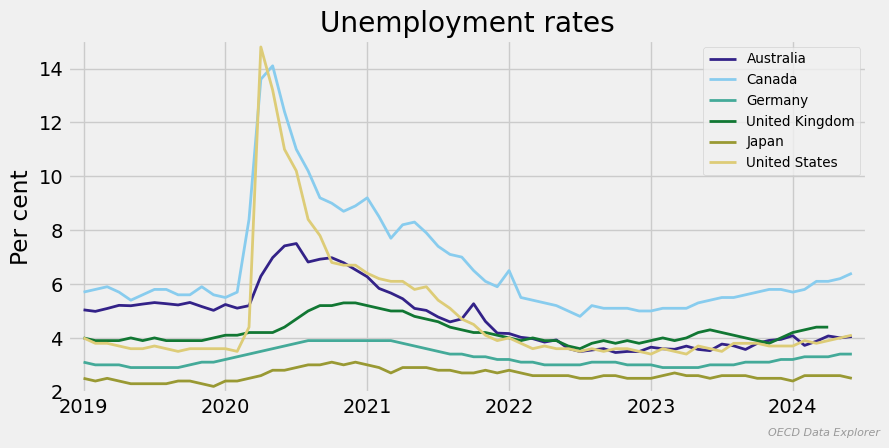

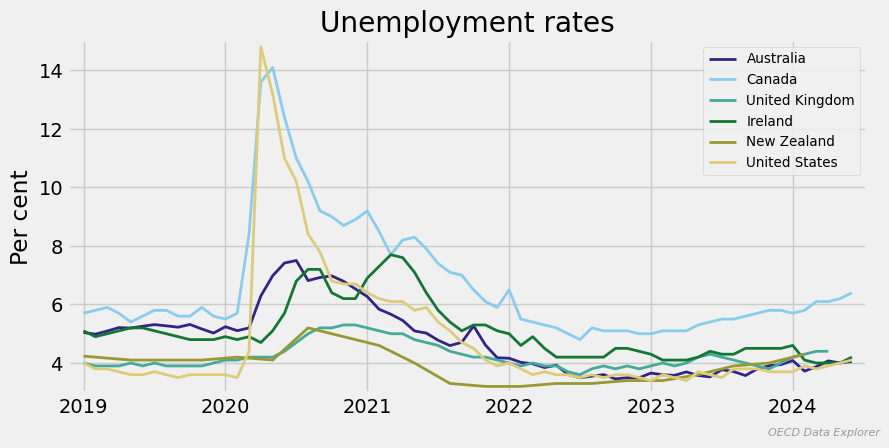

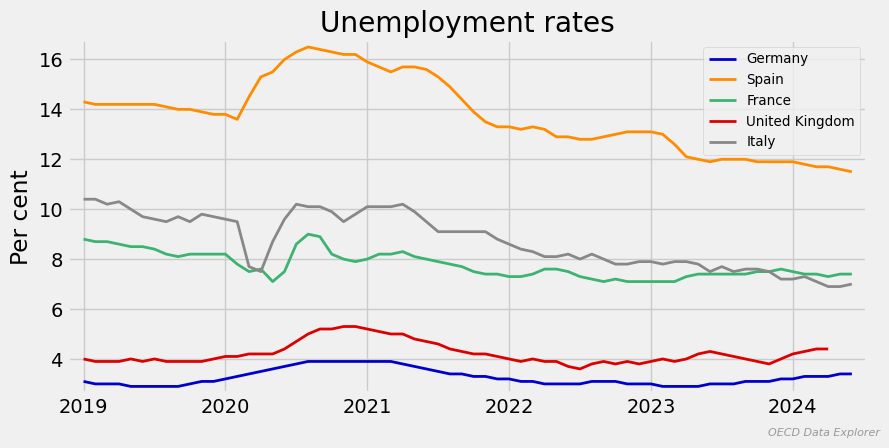

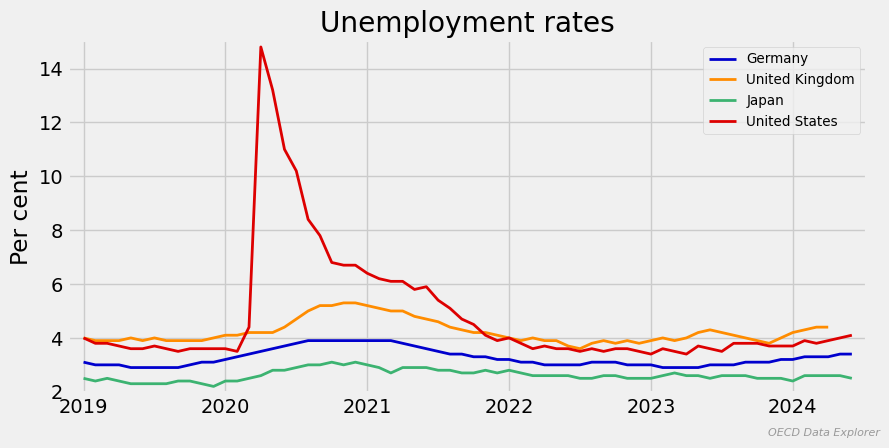

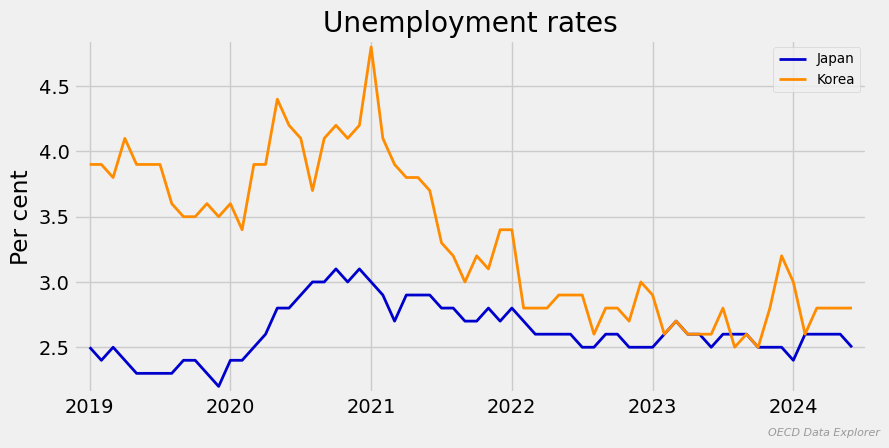

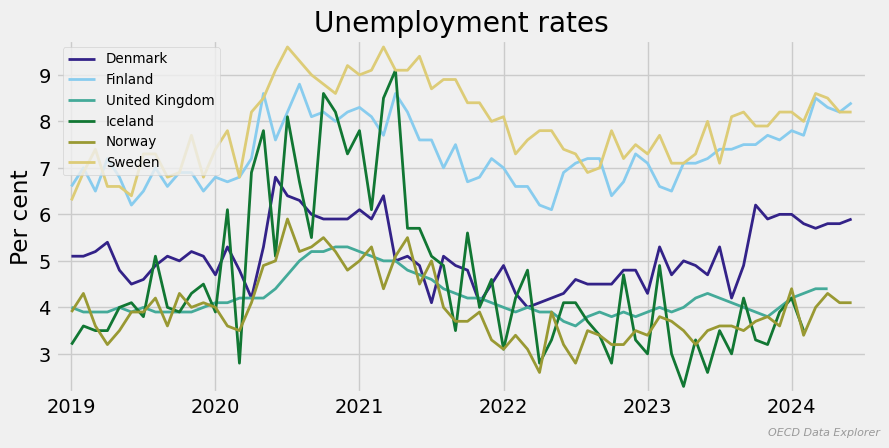

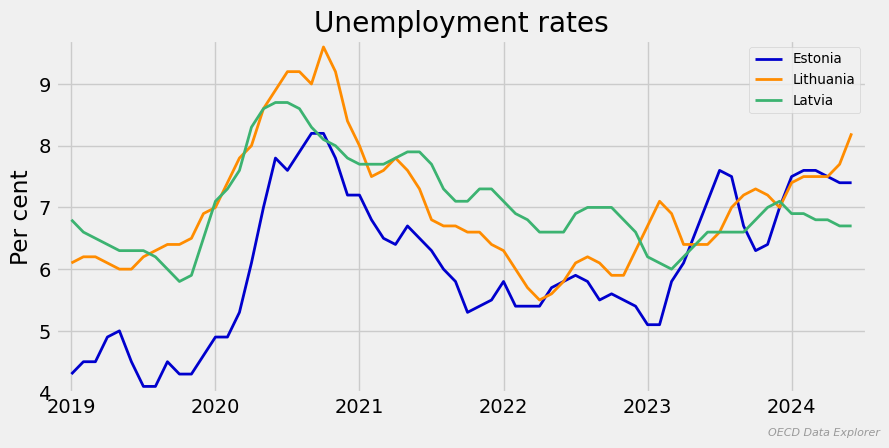

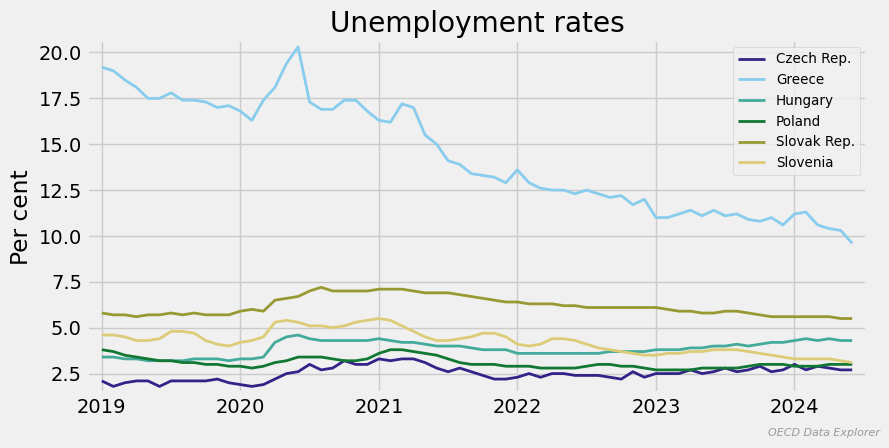

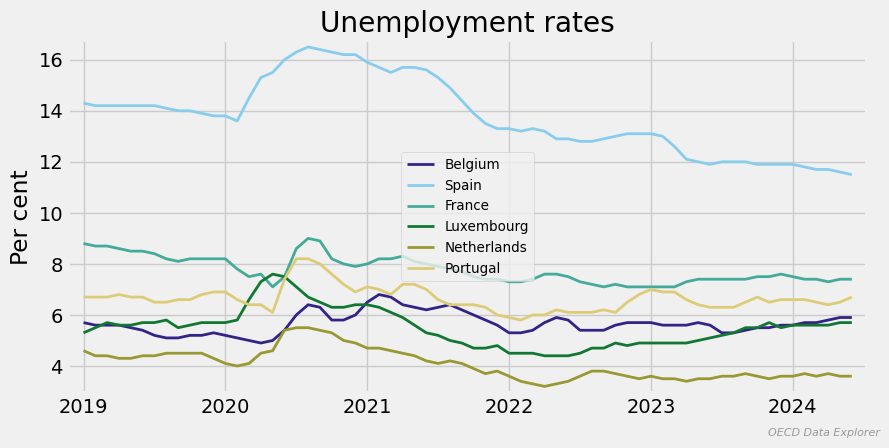

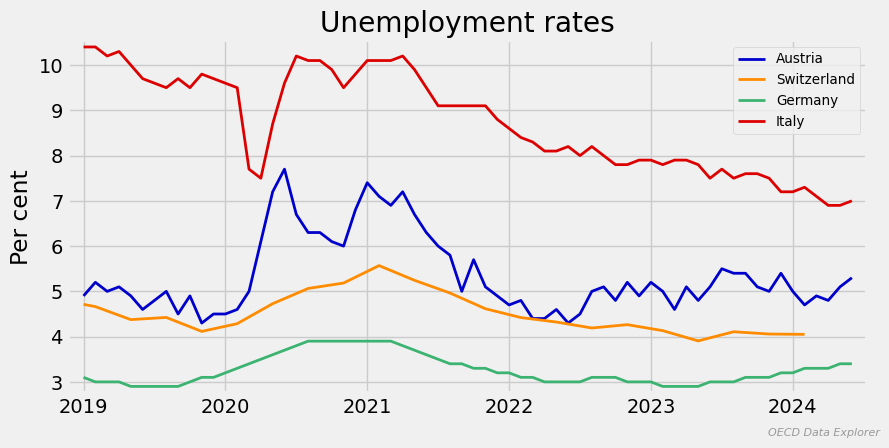

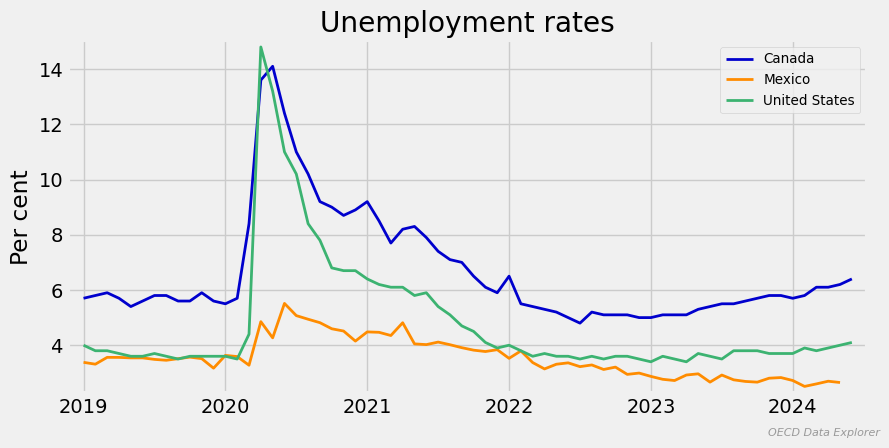

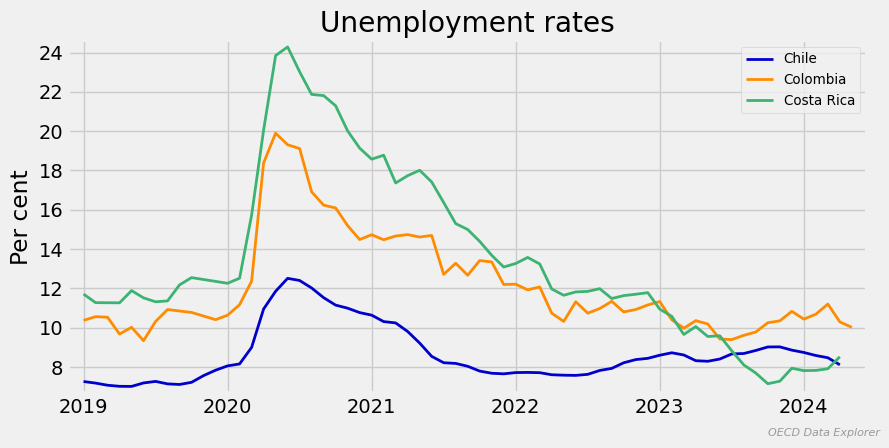

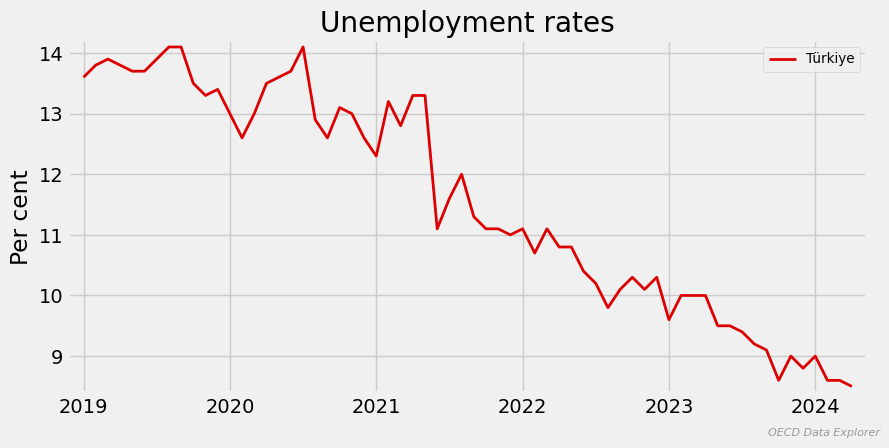

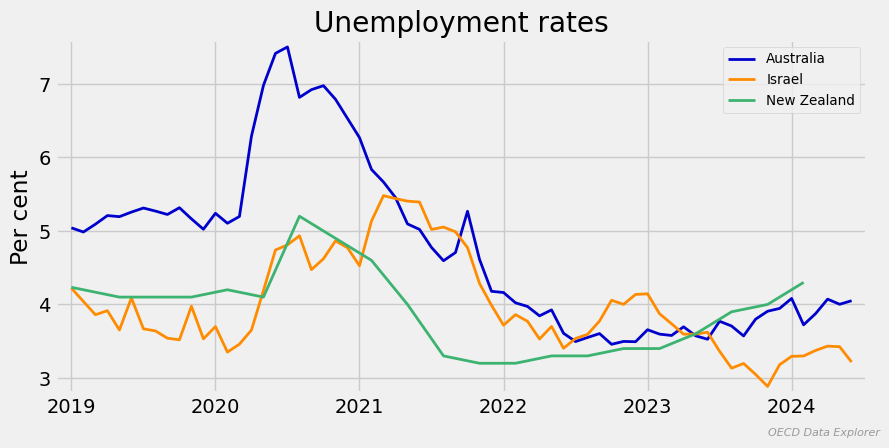

In [21]:
def plot_ue(data: pd.DataFrame) -> None:
    """Plot unemployment rate data."""

    kwargs: dict[str, Any] = {
        "title": "Unemployment rates",
        "ylabel": "Per cent",
        "legend": {"loc": "best", "fontsize": "x-small"},
    }
    plot_annual(data, **kwargs)


plot_ue(ue_rates[ue_rates.index.year >= 2019])

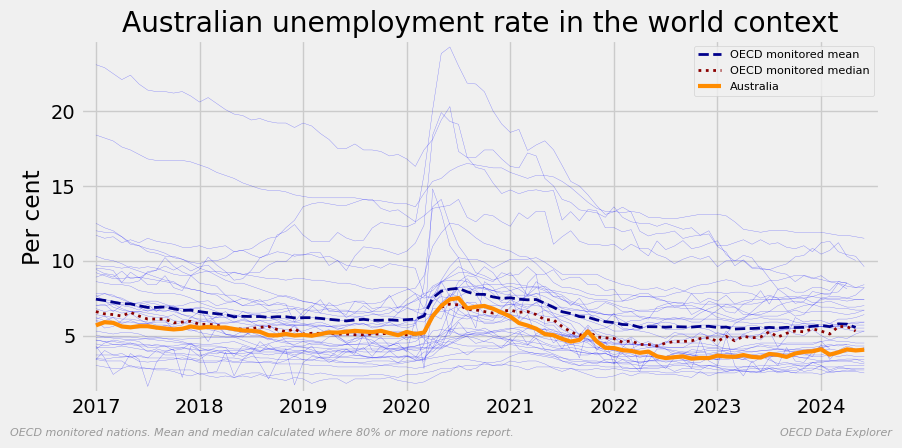

In [22]:
def plot_world_ue() -> None:
    "Plot comparative unemployment rates."

    kwargs: dict[str, Any] = {
        "title": "Australian unemployment rate in the world context",
        "ylabel": "Per cent",
        "lfooter": "OECD monitored nations. Mean and median calculated where "
        f"{int(MEAN_MEDIAN*100)}% or more nations report.",
    }
    plot_world(ue_rates[ue_rates.index.year >= 2017], **kwargs)


plot_world_ue()

In [23]:
ue_rates.tail()

REF_AREA       AUS  AUT  BEL  BGR  CAN       CHL       COL       CRI  CZE  \
2024-02   3.722715  4.7  5.7  4.7  5.8  8.587851  10.68758  7.828923  2.7   
2024-03   3.875413  4.9  5.7  4.6  6.1  8.473977  11.20423  7.913683  2.9   
2024-04   4.072182  4.8  5.8  4.6  6.1  8.114883  10.29703  8.524814  2.8   
2024-05   4.002401  5.1  5.9  4.5  6.2       NaN  10.01904       NaN  2.7   
2024-06   4.050908  5.3  5.9  4.5  6.4       NaN       NaN       NaN  2.7   

REF_AREA  DEU  ...  NOR  POL  PRT  SVK  SVN  SWE  TUR  USA       CHE  NZL  
2024-02   3.3  ...  3.4  2.9  6.6  5.6  3.3  8.0  8.6  3.9  4.050389  4.3  
2024-03   3.3  ...  4.0  2.9  6.5  5.6  3.3  8.6  8.6  3.8       NaN  NaN  
2024-04   3.3  ...  4.3  3.0  6.4  5.6  3.3  8.5  8.5  3.9       NaN  NaN  
2024-05   3.4  ...  4.1  3.0  6.5  5.5  3.2  8.2  NaN  4.0       NaN  NaN  
2024-06   3.4  ...  4.1  3.0  6.7  5.5  3.1  8.2  NaN  4.1       NaN  NaN  

[5 rows x 40 columns]

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_58221/1646681773.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ohlc_df.index, rotation=90)


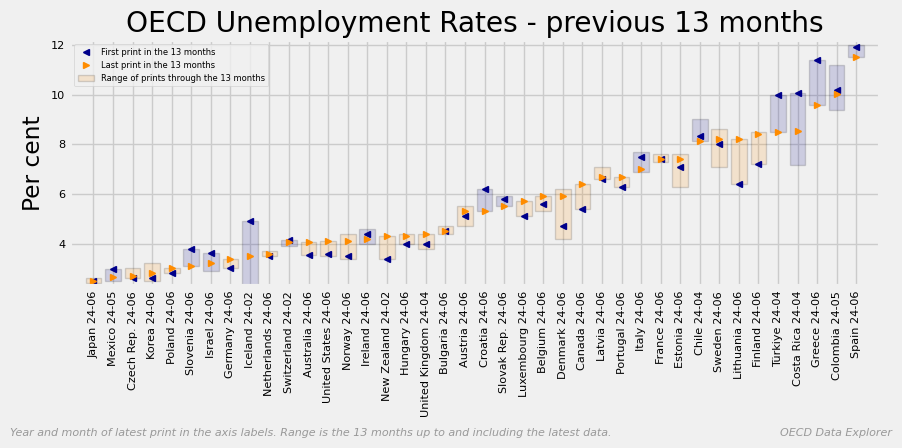

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_58221/1646681773.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ohlc_df.index, rotation=90)


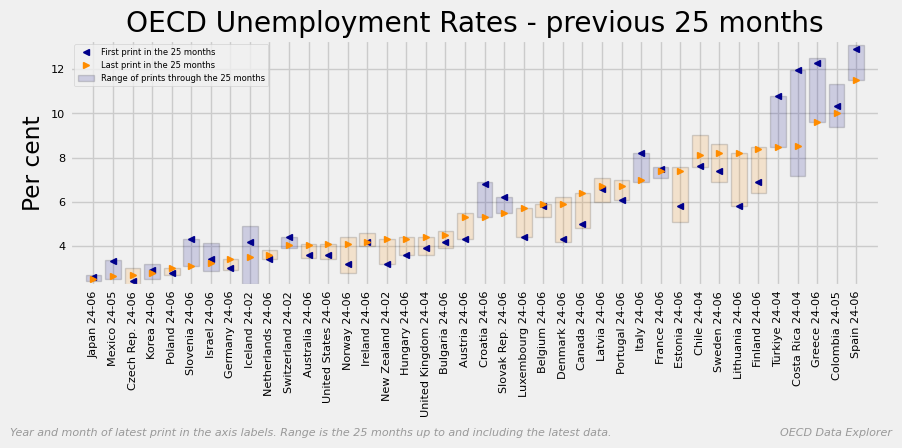

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_58221/1646681773.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ohlc_df.index, rotation=90)


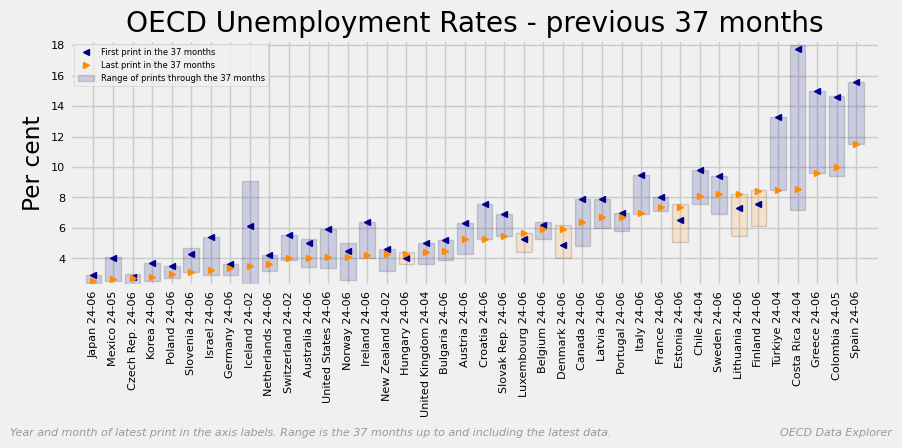

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_58221/1646681773.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ohlc_df.index, rotation=90)


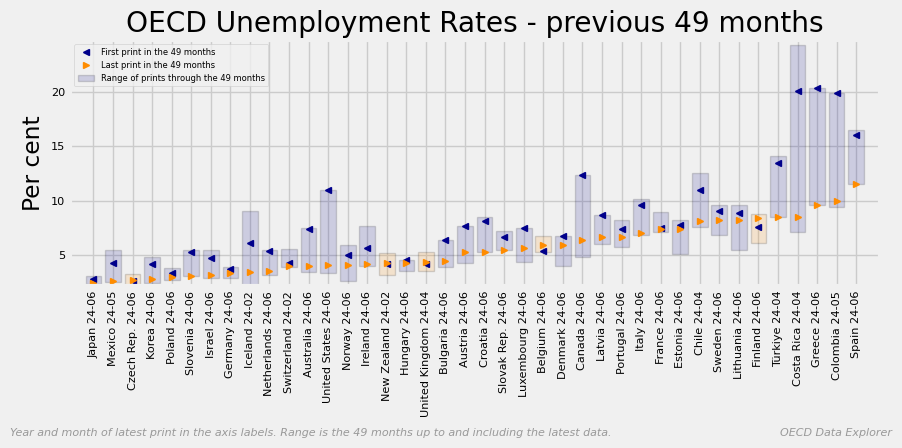

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_58221/1646681773.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ohlc_df.index, rotation=90)


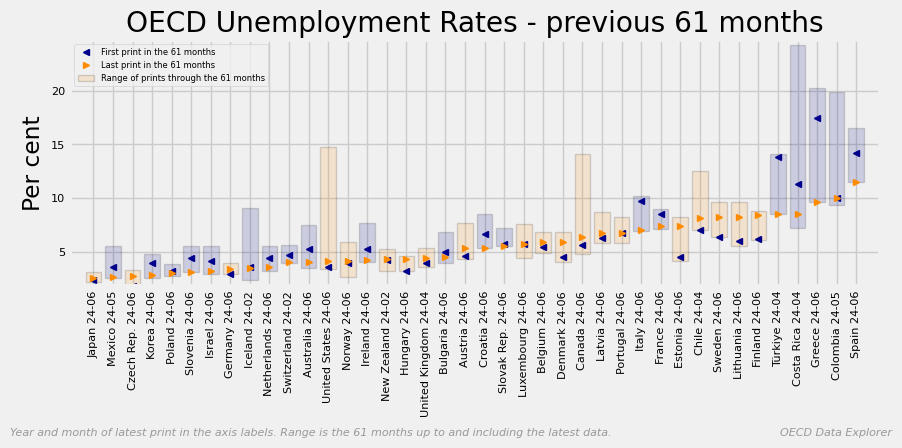

In [24]:
def plot_ohlc_ue() -> None:
    """Plot recent unemployment rate data in an OHLC style."""

    for n in [13, 25, 37, 49, 61]:
        ue_ohlc = get_recent_ohlc(ue_rates.rename(columns=location_map), n=n)
        plot_ohlc(
            ue_ohlc,
            horizontal=False,
            n=n,
            title=f"OECD Unemployment Rates - previous {n} months",
            ylabel="Per cent",
            show=SHOW,
        )


plot_ohlc_ue()

## GDP

Chain linked volume measures, national currency, seasonally adjusted

In [25]:
def get_real_gdp_qtly_growth():
    """Get real GDP (national currency / seasonally adjusted),
    and return quarterly growth."""

    agency = "OECD.SDD.NAD"
    dataflow = "DSD_NAMAIN1@DF_QNA_EXPENDITURE_NATIO_CURR,1.0"
    filter_expr = "Q.Y....B1GQ.....L.."
    options = "startPeriod=1999-Q4&dimensionAtObservation=AllDimensions"

    rgdp = get_oecd_table(agency, dataflow, filter_expr, options)
    rgdp.index = pd.PeriodIndex(rgdp.index, freq="Q")
    rgdp = remove_non_national(rgdp)
    growth = (rgdp.pct_change(fill_method=None) * 100).dropna(how="all")

    return growth


gdp = get_real_gdp_qtly_growth()
check_missing(gdp)

Removing columns: Index(['EA20', 'EU27_2020'], dtype='object')
Missing national data for Argentina, China, South Africa, India, Indonesia, Mexico
Final period: 2024Q1
Missing data count for final period: 2
Missing data belongs to: ['NZL', 'RUS']
Nations with final data: ['AUS', 'AUT', 'BEL', 'BGR', 'BRA', 'CAN', 'CHE', 'CHL', 'COL', 'CRI', 'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HRV', 'HUN', 'IRL', 'ISL', 'ISR', 'ITA', 'JPN', 'KOR', 'LTU', 'LUX', 'LVA', 'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'SAU', 'SVK', 'SVN', 'SWE', 'TUR', 'USA']


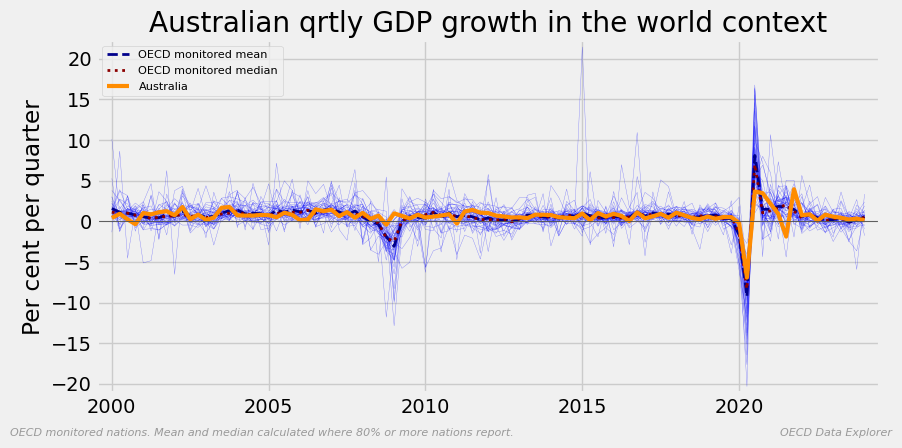

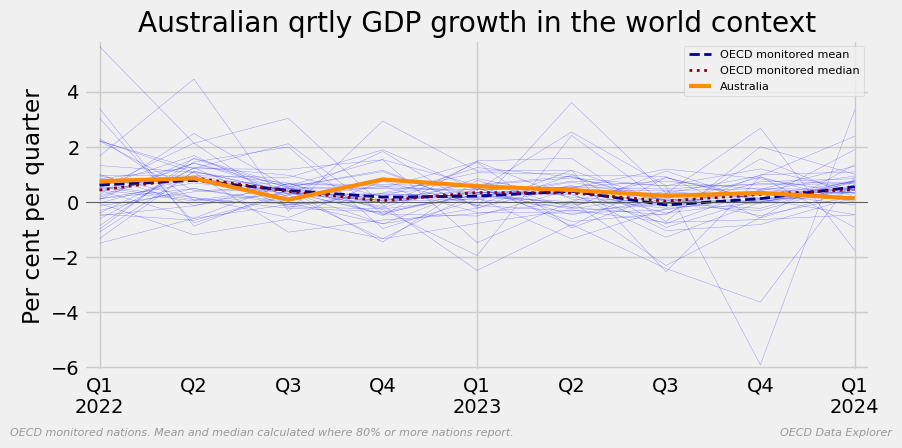

In [26]:
def plot_world_gdp() -> None:
    "Plot world GDP."

    kwargs: dict[str, Any] = {
        "title": "Australian qrtly GDP growth in the world context",
        "ylabel": "Per cent per quarter",
        "lfooter": "OECD monitored nations. Mean and median calculated where "
        f"{int(MEAN_MEDIAN*100)}% or more nations report.",
    }
    plot_world(gdp, **kwargs)
    plot_world(gdp[gdp.index.year >= 2022], **kwargs)


plot_world_gdp()

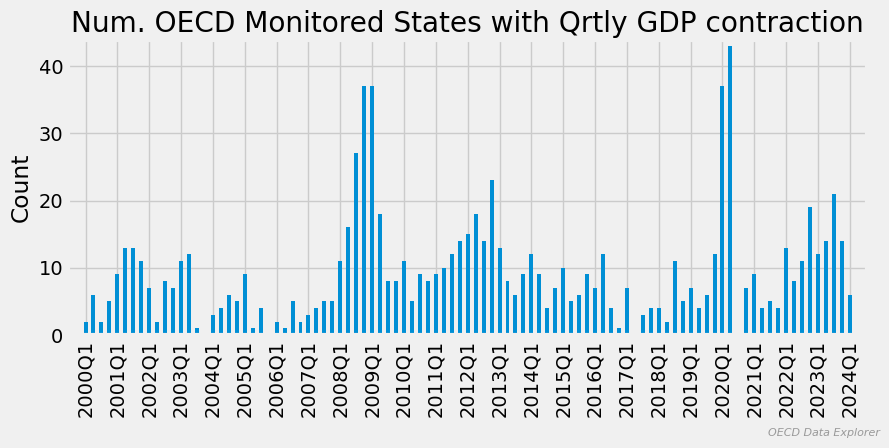

Latest nations in contraction, N=6
Denmark, Estonia, Iceland, Japan, Netherlands, Slovenia


In [27]:
def plot_contractions(growth: pd.DataFrame):
    """GDP identify/count quarterly contractions."""

    contractions = growth < 0
    contraction_count = contractions.sum(axis=1)

    start = pd.Period("2000Q1", freq="Q")
    title = "Num. OECD Monitored States with Qrtly GDP contraction"

    ax = contraction_count[contraction_count.index >= start].plot.bar()
    ax.set_xticks(ax.get_xticks()[::4])
    pg.finalise_plot(
        ax,
        title=title,
        ylabel="Count",
        rfooter=SOURCE,
        show=SHOW,
    )

    # print nations in contraction
    print(f"Latest nations in contraction, N={contraction_count.iloc[-1]}")
    print(
        ", ".join(
            [
                location_map[x]
                for x in contractions.iloc[-1][contractions.iloc[-1]].index
            ]
        )
    )


plot_contractions(gdp)

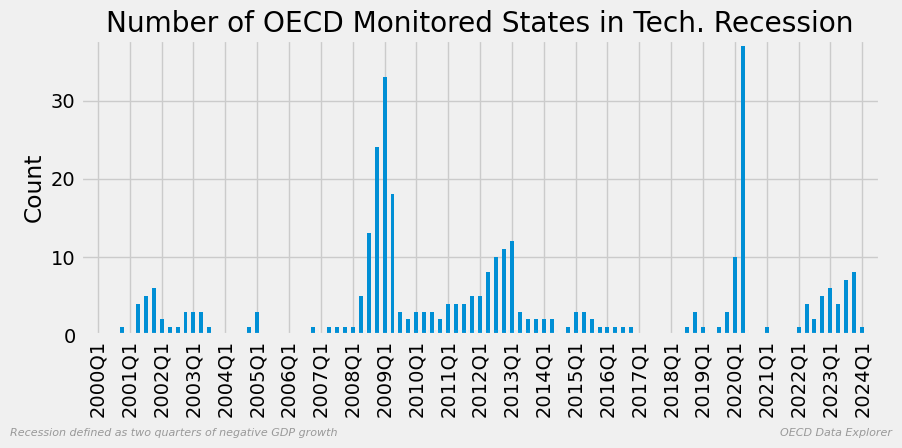

Latest N=1
Estonia


In [28]:
def plot_recessions(growth: pd.DataFrame):
    """GDP identify/count technical recessions."""

    recessions = (growth < 0) & (growth.shift(1) < 0)
    recession_count = recessions.sum(axis=1)

    title = "Number of OECD Monitored States in Tech. Recession"
    start = pd.Period("2000Q1", freq="Q")
    ax = recession_count[recession_count.index >= start].plot.bar()
    ax.set_xticks(ax.get_xticks()[::4])
    pg.finalise_plot(
        ax,
        title=title,
        ylabel="Count",
        rfooter=SOURCE,
        lfooter="Recession defined as two quarters of negative GDP growth",
        show=SHOW,
    )

    # print nations in contraction
    print(f"Latest N={recession_count.iloc[-1]}")
    print(
        ", ".join(
            [location_map[x] for x in recessions.iloc[-1][recessions.iloc[-1]].index]
        )
    )


plot_recessions(gdp)

### Recessions since COVID recovery

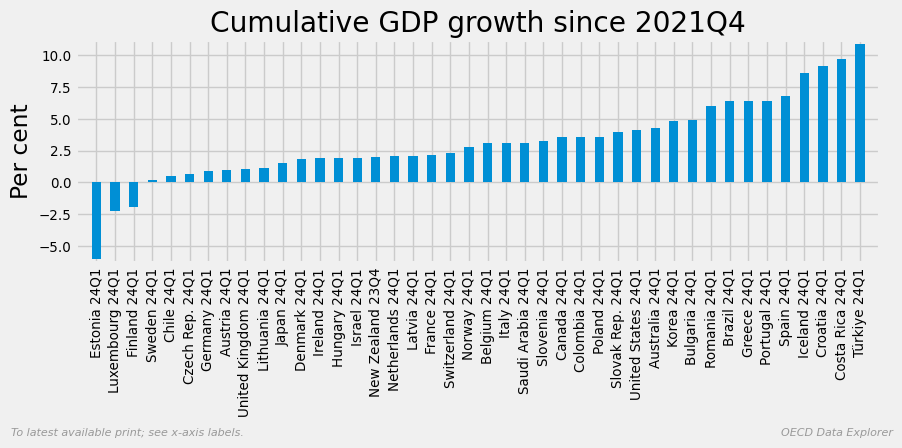

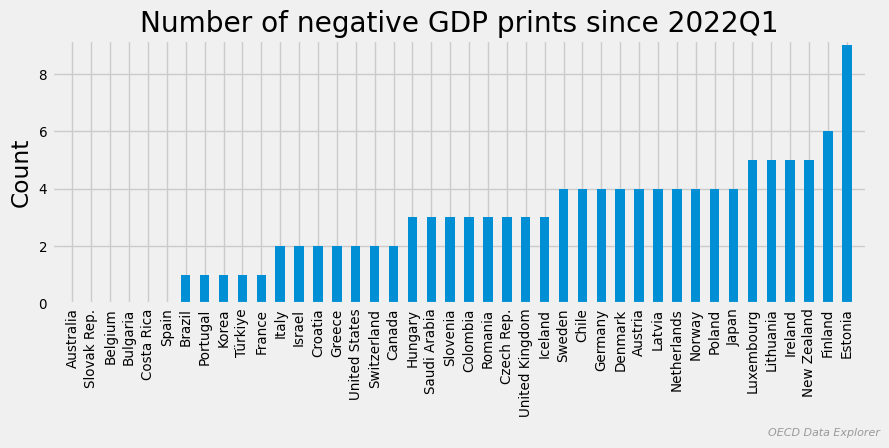

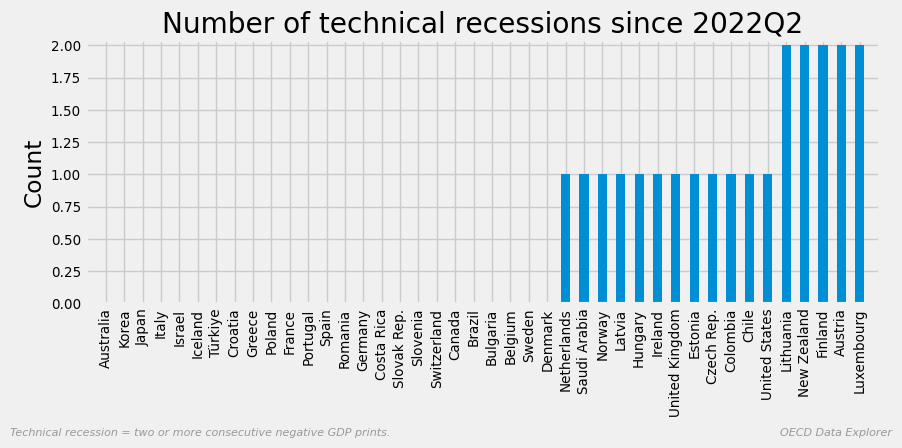

In [37]:
def post_covid_recessions(
    gdp: pd.DataFrame, start: pd.Period = pd.Period("2022Q1", freq="Q")
) -> None:
    """Identify nations in recession post COVID-19."""

    recent_gdp = (
        gdp.loc[lambda x: x.index >= start]
        .dropna(how="all", axis=1)
        .rename(columns=location_map)
    )

    # plot cumulative growth since start
    growth = ((1 + recent_gdp / 100).cumprod() - 1) * 100
    final = growth.apply(pd.Series.last_valid_index).astype(str).str[2:]  # type: ignore[type-var]
    gmap = {x: x + " " + y for x, y in final.items()}  # type: ignore[operator]
    cum_growth = {}
    for col in growth.columns:
        cum_growth[col] = growth[col].loc[growth[col].last_valid_index()]
    cum_growth_s = pd.Series(cum_growth).rename(index=gmap).sort_values()
    ax = cum_growth_s.plot.bar()
    ax.tick_params(axis="both", which="major", labelsize="x-small")
    pg.finalise_plot(
        ax,
        title=f"Cumulative GDP growth since {start-1}",
        ylabel="Per cent",
        rfooter=SOURCE,
        lfooter="To latest available print; see x-axis labels. ",
        show=SHOW,
    )

    # plot number of economic contractions
    negative = recent_gdp < 0
    contraction_count = negative.sum().sort_values()
    ax = contraction_count.plot.bar()
    ax.tick_params(axis="both", which="major", labelsize="x-small")
    pg.finalise_plot(
        ax,
        title=f"Number of negative GDP prints since {start}",
        ylabel="Count",
        rfooter=SOURCE,
        show=SHOW,
    )

    # plot number of technical recessions (two consecutive contractions)
    g = negative.ne(negative.shift()).cumsum().where(negative, other=np.nan)
    recessions = g.apply(pd.Series.value_counts)
    recessions = recessions[recessions >= 2].count().sort_values()  # type: ignore[assignment]
    ax = recessions.plot.bar()
    ax.tick_params(axis="both", which="major", labelsize="x-small")
    pg.finalise_plot(
        ax,
        title=f"Number of technical recessions since {start+1}",
        ylabel="Count",
        rfooter=SOURCE,
        lfooter="Technical recession = two or more consecutive negative GDP prints. ",
        show=SHOW,
    )


post_covid_recessions(gdp)

## Inflation 

In [30]:
EXCLUDE = ["Türkiye", "Russia", "Argentina"]
# Turkey and Argentina have rampant inflation
# Russia not updating data during war

In [31]:
def get_annual_inflation() -> pd.DataFrame:
    """Get OECD Annual Inflation Data.

    The challenges:
    - two different dataflows,
    - while most nations report monthly, some report quarterly, and
    - Australia, which reports quarterly, is included in the monthly data,
      but New Zealand is not."""

    agency = "OECD.SDD.TPS"
    dataflows = (
        "DSD_PRICES_COICOP2018@DF_PRICES_C2018_ALL,1.0",  # must be first
        "DSD_PRICES@DF_PRICES_ALL,1.0",
    )
    filter_exprs = (
        ".M.N.CPI.PA._T.N.GY",  # Monthly must be first
        ".Q.N.CPI.PA._T.N.GY",
    )

    options = "startPeriod=2019-05"

    combined = None
    for dataflow in dataflows:
        for filter_expr in filter_exprs:
            pvt = get_oecd_table(agency, dataflow, filter_expr, options)
            pvt.index = pd.PeriodIndex(pvt.index, freq="M")
            if filter_expr[1] == "Q":
                pvt = fix_monthly(pvt)
            combined = combine(combined, pvt)
            time.sleep(WEB_DELAY)  # just to be nice to the server.

    return remove_non_national(cast(pd.DataFrame, combined))


annual_inflation = get_annual_inflation()
# Move Australia and NewZealand to the end of the quarter
# we do this because the OECD places the quarterly data in the mid-quarter month
annual_inflation[["AUS", "NZL"]] = annual_inflation[["AUS", "NZL"]].shift(1)
display(annual_inflation[["AUS", "NZL"]].tail(7))

Removing columns: Index(['EA20', 'EU27_2020', 'G20', 'G7', 'OECD', 'OECDE'], dtype='object')


REF_AREA       AUS       NZL
2023-12   4.051988  4.655029
2024-01        NaN  4.444349
2024-02        NaN  4.233668
2024-03   3.619910  4.022988
2024-04        NaN  3.792201
2024-05        NaN  3.561413
2024-06   3.814510  3.330626

In [32]:
check_missing(annual_inflation)

Missing national data for Romania
Final period: 2024-06
Missing data count for final period: 4
Missing data belongs to: ['BGR', 'HRV', 'IND', 'RUS']
Nations with final data: ['CHL', 'CRI', 'JPN', 'ARG', 'AUS', 'AUT', 'BEL', 'BRA', 'CAN', 'CHE', 'CHN', 'COL', 'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HUN', 'IDN', 'IRL', 'ISL', 'ISR', 'ITA', 'KOR', 'LTU', 'LUX', 'LVA', 'MEX', 'NLD', 'NOR', 'POL', 'PRT', 'SAU', 'SVK', 'SVN', 'SWE', 'TUR', 'USA', 'ZAF', 'NZL']


/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_58221/1646681773.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ohlc_df.index, rotation=90)


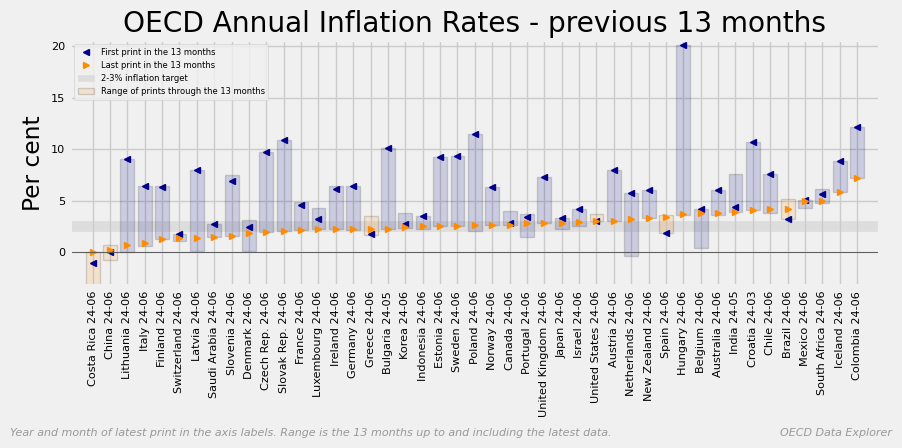

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_58221/1646681773.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ohlc_df.index, rotation=90)


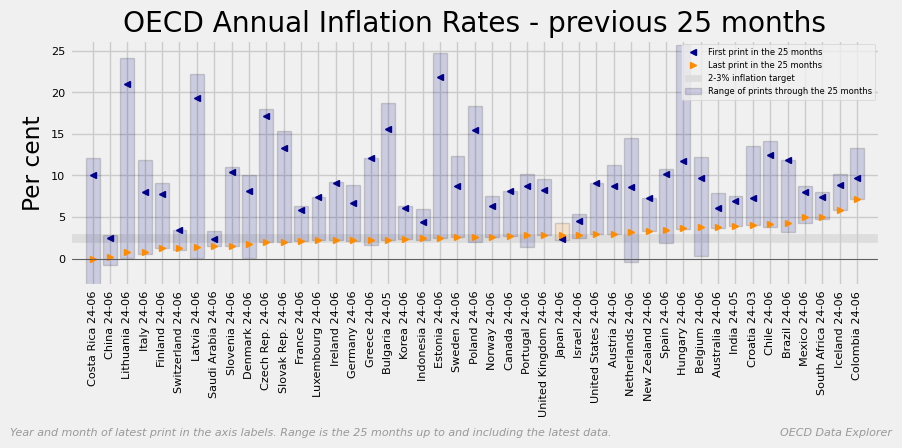

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_58221/1646681773.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ohlc_df.index, rotation=90)


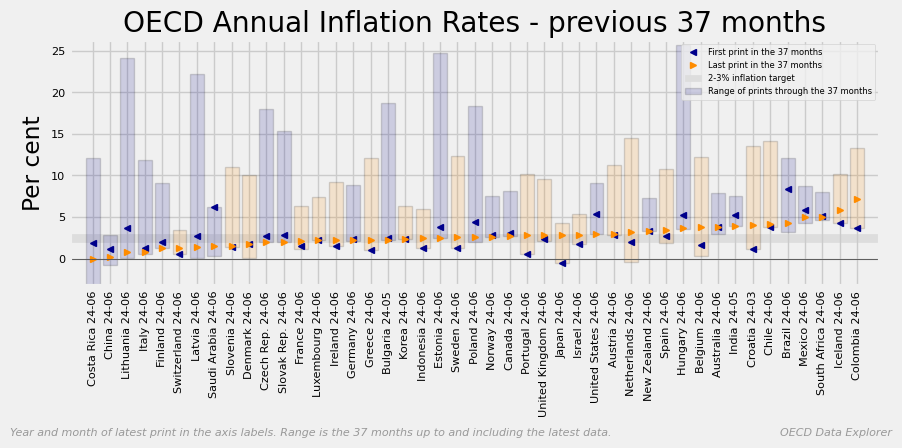

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_58221/1646681773.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ohlc_df.index, rotation=90)


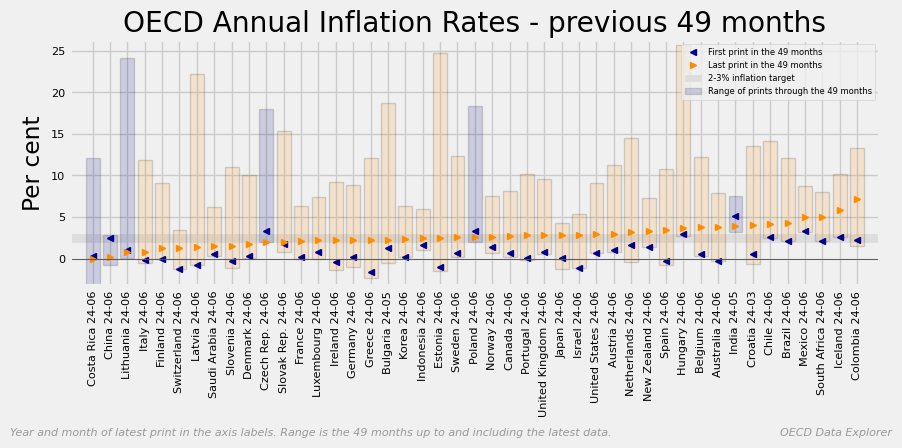

In [33]:
def plot_ohlc_inf() -> None:
    """Plot recent unemployment rate data in an OHLC style."""

    for n in [13, 25, 37, 49]:
        ohlc = get_recent_ohlc(
            annual_inflation.rename(columns=location_map), n=n, exclude=EXCLUDE
        )
        plot_ohlc(
            ohlc,
            horizontal=False,
            n=n,
            title=f"OECD Annual Inflation Rates - previous {n} months",
            ylabel="Per cent",
            axhspan=TARGET,
            show=SHOW,
        )


plot_ohlc_inf()

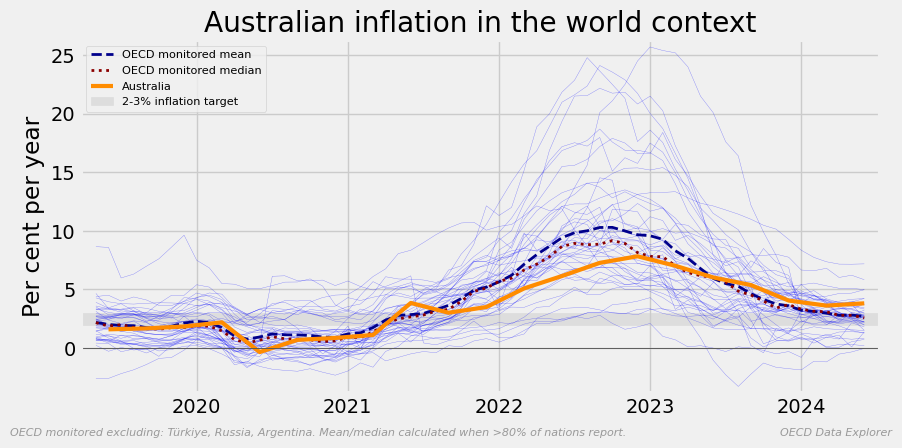

In [34]:
def plot_world_inflation():
    "Plot World Inflation."

    kwargs = {
        "title": "Australian inflation in the world context",
        "ylabel": "Per cent per year",
        "lfooter": f'OECD monitored excluding: {", ".join(EXCLUDE)}. '
        f"Mean/median calculated when >{int(MEAN_MEDIAN*100)}% of nations report.",
        "axhspan": TARGET,
    }

    plot_world(
        annual_inflation,
        exclusions=EXCLUDE,
        **kwargs,
    )


plot_world_inflation()

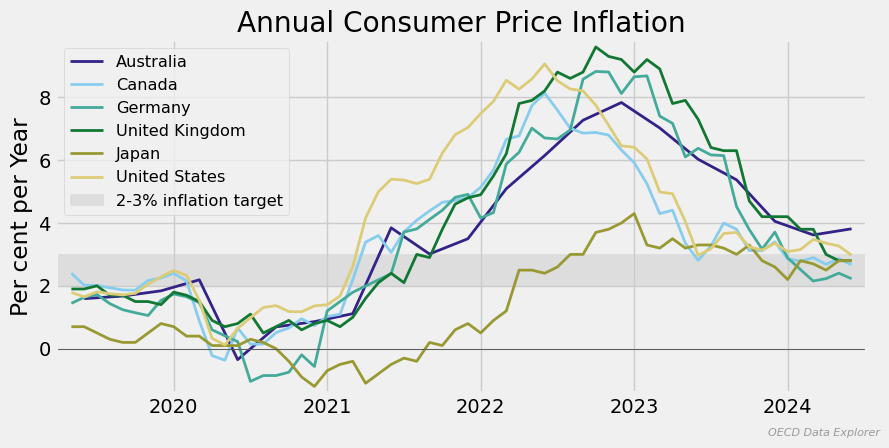

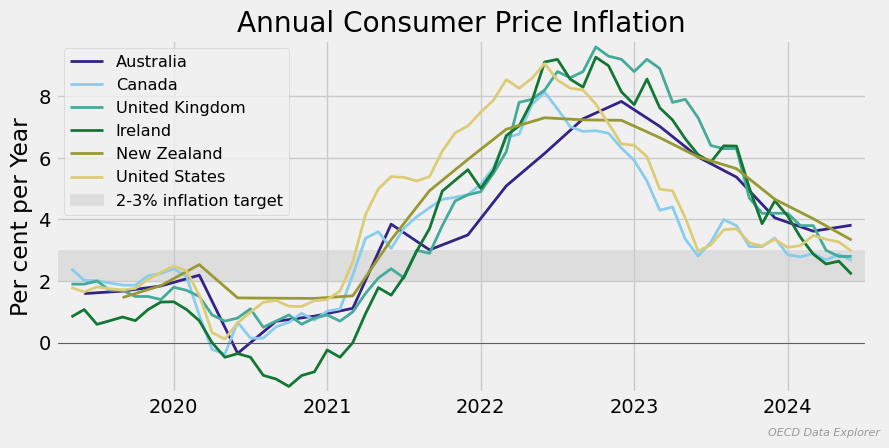

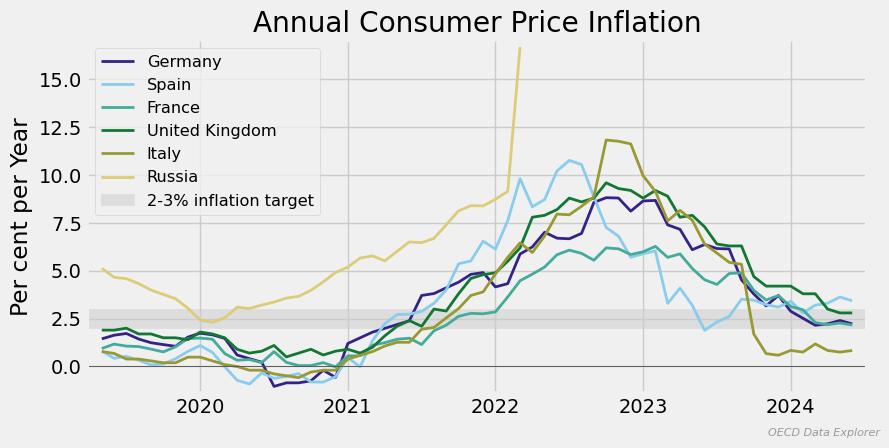

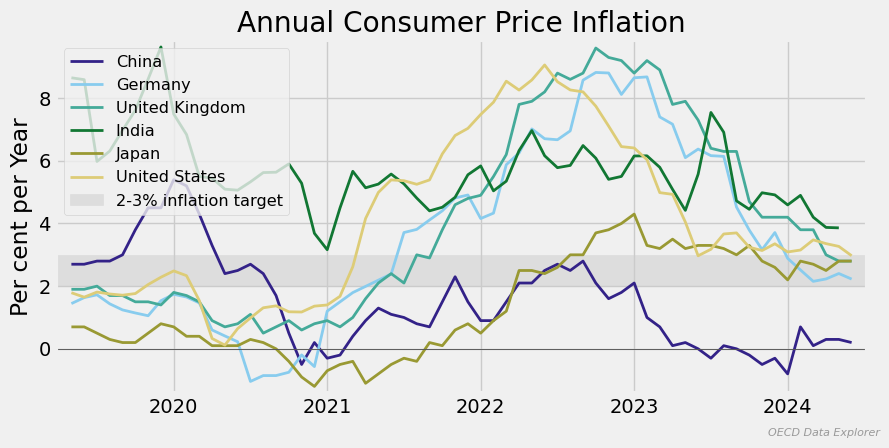

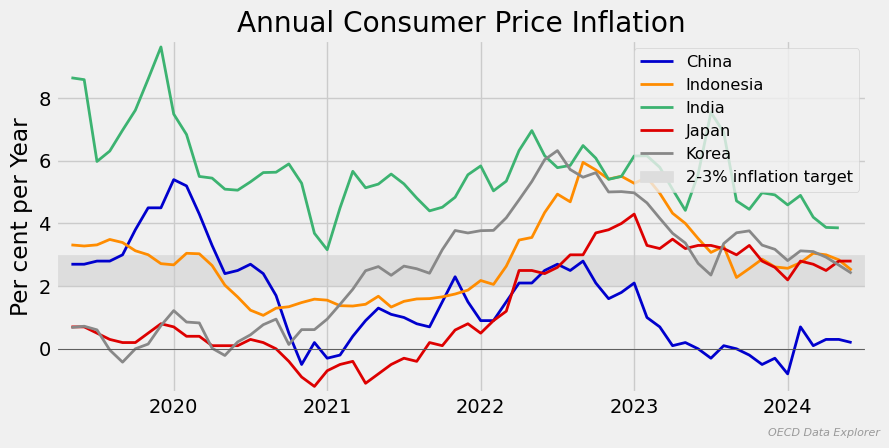

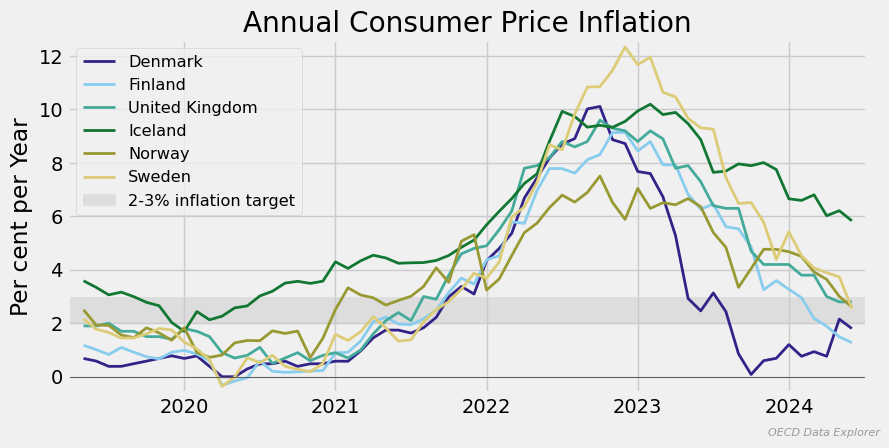

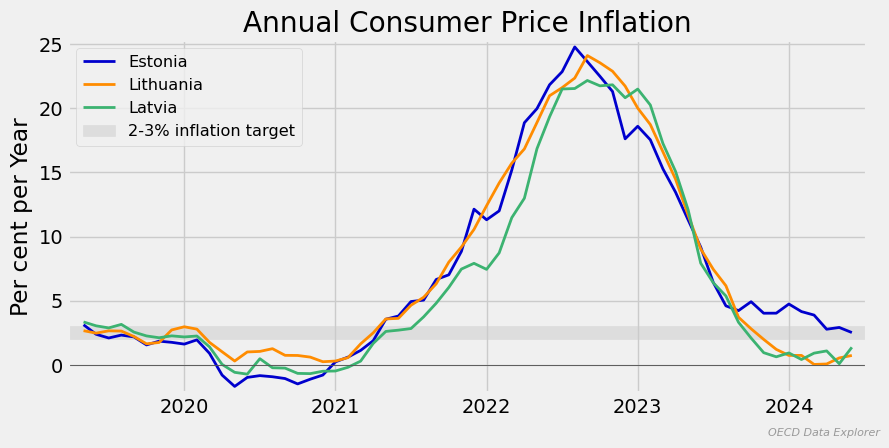

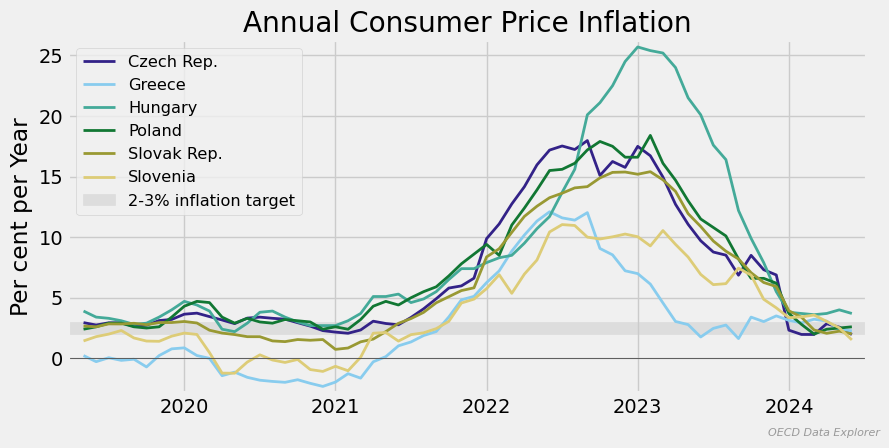

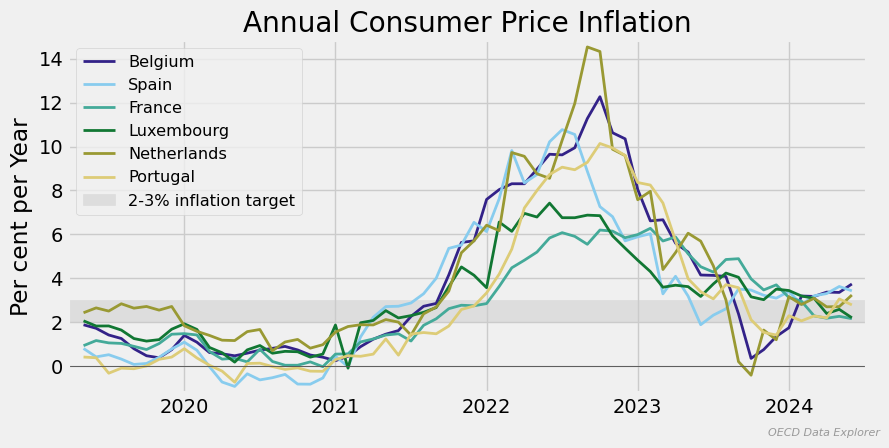

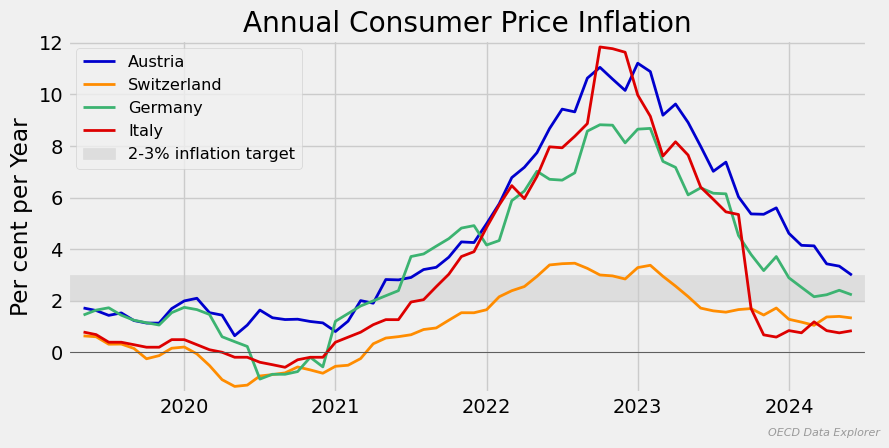

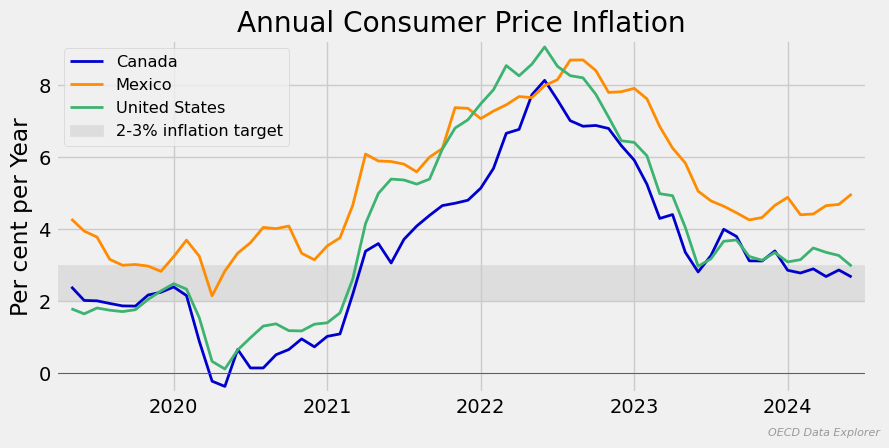

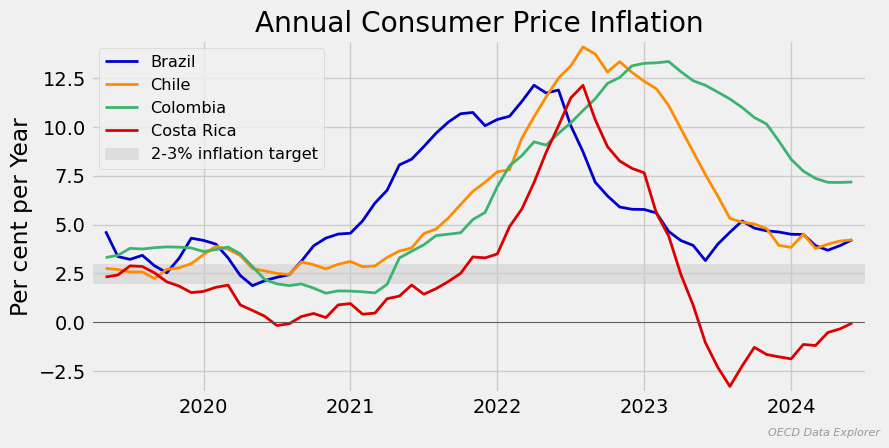

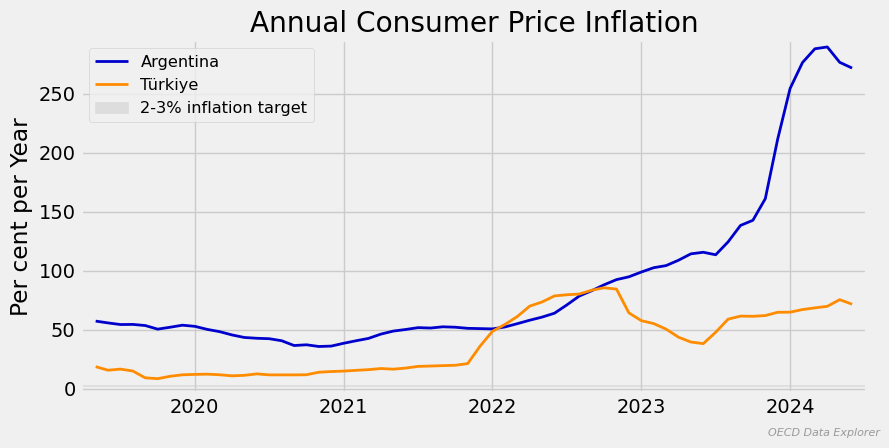

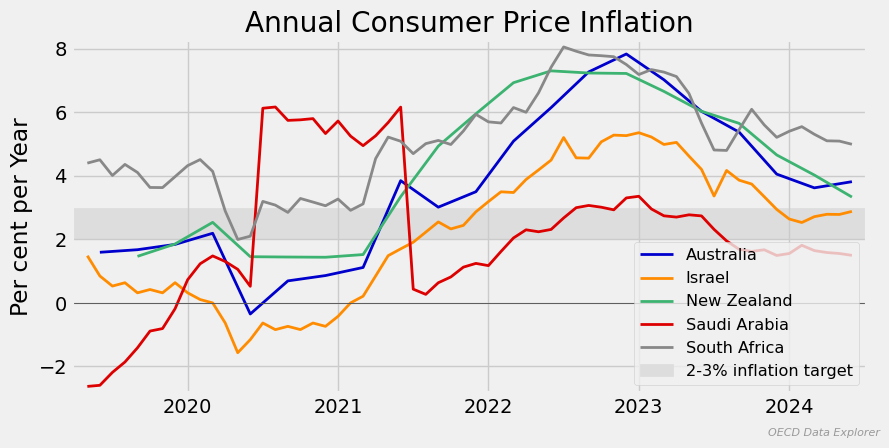

In [35]:
def plot_annual_inflation(data: pd.DataFrame):
    "Plot annual inflation."

    kwargs = {
        "title": "Annual Consumer Price Inflation",
        "ylabel": "Per cent per Year",
        "axhspan": TARGET,
    }
    plot_annual(data, **kwargs)


plot_annual_inflation(annual_inflation)

## Finished

In [36]:
%reload_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Fri Aug 02 2024 20:28:35

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

numpy     : 1.26.4
pandas    : 2.2.2
matplotlib: 3.9.1

Watermark: 2.4.3

